In [1]:
import tqdm
import torch
import torchaudio
import mne
import torchaudio.functional as F
import torchaudio.transforms as T
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import RobustScaler, robust_scale

### Setup

In [2]:
# channel names
EEG = mne.io.read_raw_brainvision('data/test/sub-032301/RSEEG/sub-010002.vhdr', eog=['VEOG'])
ch_names = EEG.info['ch_names']
ch_names.remove('VEOG')
del EEG

# helper function to load the data
# Helper functions
# clamp
def clamp_eeg(data, axis=1, deviation=20):
    """Clamp EEG data proportional to the standard deviation of each channel."""
    # container for clamped data
    data_clamped = np.zeros_like(data)
    upper_dev = data.mean(axis=axis) + data.std(axis=axis) * deviation
    lower_dev = data.mean(axis=axis) - data.std(axis=axis) * deviation
    for i in range(data.shape[0]):
        data_clamped[i, :] = np.clip(data[i, :], lower_dev[i], upper_dev[i])
    return data_clamped

def print_min_max(data, lower_dev, upper_dev, sub, channel):
    """Prints the min and max of a channel and checks if it would be clamped by the clamp_eeg function
    This is used to check if the clamp function is working as expected."""
    if data[sub, channel, :].min() < lower_dev[sub, channel] or data[sub, channel, :].max() > upper_dev[sub, channel]:
        print(f'Data: {sub}, {channel}: Min={data[sub, channel, :].min()}, Max={data[sub, channel, :].max()}',
              f'Bounderies: Lower={lower_dev[sub, channel]}, Higher={upper_dev[sub, channel]}')

def power_to_db(S, ref=1.0, amin=1e-10, top_db=80.0):
    ref_value = torch.tensor(ref)
    amin = torch.tensor(amin)
    log_spec = 10.0 * torch.log10(torch.maximum(amin, S))
    log_spec -= 10.0 * torch.log10(torch.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise ValueError("top_db must be non-negative")
        log_spec = torch.maximum(log_spec, log_spec.max() - top_db)

    return log_spec

Extracting parameters from data/test/sub-032301/RSEEG/sub-010002.vhdr...
Setting channel info structure...


### Preprocessing

In [ ]:
# load the data
data = xr.open_dataarray('data/processed/baseline_corrected/eeg_EC_BaseCorr.nc5', engine='h5netcdf')
subjects = data.subject.values

# an xarray container for collecting procesed data across subjects
processed_data = {}

for sub in tqdm.tqdm(subjects):
  print(f'Processing {sub}')
  sub_data = data.sel(subject=sub).values

  # normalize
  sub_data = RobustScaler().fit_transform(sub_data)

  # clamp
  sub_data = clamp_eeg(sub_data)

  processed_data[sub] = sub_data

# save the processed data
data = xr.DataArray(np.array(list(processed_data.values())),
                    dims=('subject', 'channel', 'time'),
                    coords={'subject': list(processed_data.keys()),
                            'channel': ch_names})
# data.to_netcdf('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp.nc5', engine='h5netcdf')

### Feature extraction
#### time-frequency analysis

In [ ]:
# open processed eeg data
DATA = xr.open_dataarray('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp.nc5', engine='h5netcdf')
subjects = DATA.subject.values

tfrs = {}

# morlet wavelet transform
freqs = np.arange(3, 30, 2)  # TODO: I used 7 as the lower boundery but will change it to 3 as it is now
n_cycles = [np.ceil(i) for i in freqs/(freqs[0]-2)]

for sub in subjects:
    print(f'Processing {sub}')
    data_sub = DATA.sel(subject=sub).values
    data_sub = np.expand_dims(data_sub, axis=0)  # add an additional dimension to the data
    tfr = mne.time_frequency.tfr_array_morlet(data_sub, freqs=freqs, sfreq=128, n_cycles=n_cycles,
                                              output='power',
                                              n_jobs=-1, verbose=0)

    # maybe only the spatial and frequency dimensions are important, so we can average over the time dimension
    # Because our data is not time-locked!
    tfrs[sub] = tfr.squeeze().mean(axis=-1)

# convert the dictionary to a xarray
tfrs = xr.DataArray(np.array(list(tfrs.values())),
                    dims=('subject', 'channels', 'freqs'),
                    coords={'subject': list(tfrs.keys()),
                            'channels': ch_names,
                            'freqs': freqs}
                    )
# save the tfrs
tfrs.to_netcdf('data/TFR/tfrs.nc5', engine='h5netcdf')

#### Plot Frequency-Channel

In [ ]:
# open tfrs
tfrs = xr.open_dataarray('data/TFR/tfrs.nc5', engine='h5netcdf')
subjects = tfrs.subject.values
min_max = []

for sub in subjects[:10]:
    print(f'Processing {sub}')
    tfr = tfrs.sel(subject=sub).values
    tfr = power_to_db(torch.tensor(tfr))

    # plot heatmap of the average power over time (frequency x channels)
    plt.imshow(tfr, aspect='auto', origin='lower', cmap='jet')
    plt.xticks([])
    plt.yticks([])

    # save the plot
    plt.savefig(f'data/figures/tfr_heatmap_{sub}.png')

### CNN-AE

In [103]:
import torch.nn as nn
input = tfr.unsqueeze(0).float()
input2 = torch.tensor(tfrs.to_numpy()).float()
batch_size = input.shape[0]

#### Encoder
encoder = nn.Sequential(nn.Conv2d(batch_size, 61, 2, bias=False),
nn.BatchNorm1d(60, False),                       
nn.Conv2d(61, 32, 2, bias=False),
nn.BatchNorm1d(59, False)
)
#### Decoder
decoder = nn.Sequential(nn.ConvTranspose2d(32, 10, 2),
                        nn.ConvTranspose2d(10, batch_size, 2))

out = encoder(input)
out2 = decoder(out)


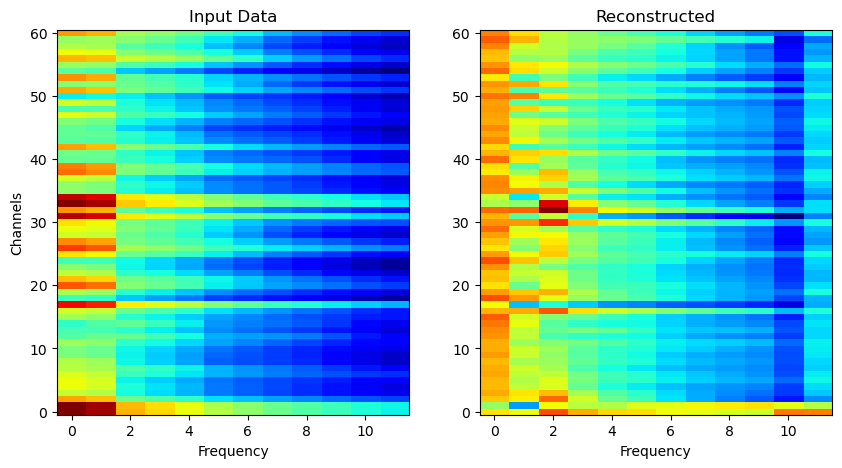

In [131]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].imshow(tfr, aspect='auto', origin='lower', cmap='jet')
axs[0].set_title('Input Data')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Channels')

axs[1].imshow(out2[0, :, :].detach().numpy(), aspect='auto', origin='lower', cmap='jet')
axs[1].set_title('Reconstructed')
axs[1].set_xlabel('Frequency')
plt.show()

## TorchAudio.Transform.Spectogram
This section tests the impact of different variables on calculating the spectogram.

In [2]:
from src.EEGNet.dataloader.dataloader import TimeDimSplit
from pathlib import Path
import torch.functional as F
import torchaudio as ta
import torch.nn.functional as F
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

# helper functions
def power_to_db(x, ref=1.0, amin=1e-10, top_db=80.0):
    x = x.abs().pow(2)
    ref = ref**2
    val = 10.0 * torch.log10(torch.clamp(x, min=amin, max=np.inf))
    if top_db is not None:
        val = torch.max(val, val.max() - top_db)
    return val

def pad_multiple(x: torch.Tensor, base: int):
    length = x.shape[-1]
    target = math.ceil(length / base) * base
    return torch.nn.functional.pad(x, (0, target - length))

# parameters
n_fft = 256
fft_complex = False
in_channels = 61

if n_fft is not None:
    pad = n_fft // 4
    kernel = n_fft
    stride = n_fft // 2

in_channels *= n_fft // 2 + 1
if fft_complex:
    in_channels *= 2

# Data
data_dir = Path('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5')
data = TimeDimSplit(data_dir=data_dir, batch_size=512, segment_size=128 * 4, n_subjects=1)
data.prepare_data()

### Are the STFT and torchaudio.spectogram the same
If we use the same parameter, but the spectogram function recieves 3D inputs with the first axis being the batch.

In [ ]:
x = data.train_dataset.tensors[0].permute(0, 2, 1)
stft = ta.transforms.Spectrogram(n_fft=256, normalized=False, power=None)
torch_sfft = torch.stft(x[0, :, :],
                        n_fft=256, hop_length=128,
                        normalized=False,
                        window=torch.hann_window(256, periodic=True,
                        dtype=torch.float32), return_complex=True)
z = stft(x)
torch_sfft == z

### Inverse Fourier Transform
and compare it with the original signal

In [ ]:
import torchaudio.transforms as T
import torch.nn as nn

# Assuming data.train_dataset.tensors[0] contains your input waveform
x = data.train_dataset.tensors[0].permute(0, 2, 1)

# Spectrogram transformation
# if we normalize the x_hat and x will not be equal
# we need to return the complex values to be able to reconstruct the signal so power = None
# use z.abs() to get the magnitude of the complex numbers, that equals to use power=1 in the function.
# z.abs() method is equal to (z.real.pow(2) + z.imag.pow(2)) ** 0.5
stft = T.Spectrogram(n_fft=256, hop_length=128, power=None, normalized=False)
z = stft(x)

# Inverse Spectrogram transformation
inverse = T.InverseSpectrogram(n_fft=256, hop_length=128)
x_hat = inverse(z)

# the x and x_hat are nearly equal
torch.allclose(x, x_hat)

In [ ]:
n_channels = 61
import torch.nn as nn
encoder_conv = nn.Sequential(
            nn.Conv1d(n_channels, n_channels * 2, kernel_size=4, stride=2, bias=False),
            # nn.ReLU(),
            # nn.Conv1d(n_channels * 2, n_channels * 4, kernel_size=4, stride=2, bias=False),
            # nn.ReLU(),
            # nn.Conv1d(n_channels * 4, n_channels * 8, kernel_size=4, stride=2, bias=False),
            # nn.ReLU(),
            # nn.Flatten(),
        )
encoder_conv(z.mean(-1)).shape